In [33]:
import csv
import collections
import numpy as np
import cvxpy as cp
import copy
import matplotlib.pyplot as plt

In [3]:
num_buses = 6
num_gen = 3
generators = np.array([0,2,5]) # indexing so -1
cost_vec = np.array([100.0, 150.0, 240.0]) # cost of each generator
carbon_emission_rate_vec = np.array([2388.0, 904.0, 321.0]) # carbon emission of each generator co2/mhw
graph = collections.defaultdict(list) # from: (to, line)
graph_reverse = collections.defaultdict(list) # to: (from, line)
line_to_nodes = []
with open('6bus_topology.csv', 'r') as csvfile:
    #next(csvfile)
    for line in csvfile:
        l = list(map(lambda x: int(x)-1, line.split(','))) # turn "1,2" to [1,2]
        graph[l[0]].append((l[1], len(line_to_nodes)))
        graph_reverse[l[1]].append((l[0], len(line_to_nodes)))
        line_to_nodes.append(l)
num_lines = len(line_to_nodes)
load = np.random.uniform(0.2, 1.8, (num_buses, 1)) # load vector i.e. power demand at each bus/node
line_flow_limit = np.full((num_lines, 1), 1.0) # largest line flow rate is 4.0
neg_line_flow_limit = np.full((num_lines, 1), -1.0) # smallest is -4.0
power_generation_limit = np.full((num_gen, 1), 3.0) # upper limit is 15
neg_power_generation_limit = np.full((num_gen, 1), 0.0) # lower power generation limit is 0

In [61]:
def get_avg_carbon(load):
    graph_copy = copy.deepcopy(graph)
    graph_reverse_copy = copy.deepcopy(graph_reverse)
    power_generation = cp.Variable(shape=(num_gen, 1)) # shape [num_gen, 1]
    line_flow = cp.Variable(shape=(num_lines, 1)) # shape [num_line, 1]
    # condition 5(b)
    b = np.zeros((num_buses, num_gen), dtype=float) # a matrix to convert power_generation from [x1, x2, x3, x4, x5, x6] to [x1, x2, 0,0,0,0,0,0,0,0,0,x3, ...] of size 30*1
    # b @ power_generation = new_power_generation
    for i, v in enumerate(generators):
        b[v][i] = 1.0
    a = np.zeros((num_buses, num_lines), dtype=float) # this matrix uses ie. 1.0/-1.0 to represent inflow/outflow. 
    # for example, line 0 is [1,2], which means power flows from bus 1 to bus 2 at line flow rate x0 at line 0. 
    # We would -x0 at index 0 of new line flow and +x0 at index 1 of new line flow. 
    # So the new line flow of shape [num_bus, 1] means at each bus/node, what is the power flow (inflow-outflow at the node).
    for i, v in enumerate(line_to_nodes):
        a[v[0]][i] = 1.0
        a[v[1]][i] = -1.0

    prob = cp.Problem(cp.Minimize(cp.sum(cost_vec @ power_generation)), # eq 5(a)
                    [b @ power_generation - load == a @ line_flow, # eqation 5(b) meaning: at each node/bus the power generated at this bus(some bus are generator) + the power inflow(can be negative) == the power demand at the bus
                    line_flow <= line_flow_limit, # eq 5(c)
                    line_flow >= neg_line_flow_limit, # eq 5(c)
                    power_generation <= power_generation_limit, # eq 5(d)
                    power_generation >= neg_power_generation_limit]) # eq 5(d)
    print(prob.status)
    prob.solve(solver=cp.CVXOPT, verbose=True)
    print(power_generation.value)
    for i, f in enumerate(line_flow.value):
        if f < 0.0:
            from_node, to_node = line_to_nodes[i]
            graph_copy[from_node].remove((to_node, i))
            graph_copy[to_node].append((from_node, i))
            graph_reverse_copy[to_node].remove((from_node, i))
            graph_reverse_copy[from_node].append((to_node, i))
            line_flow.value[i] = -f
    line_to_gen = collections.defaultdict(set)
    node_to_gen = collections.defaultdict(set)
    def dfs(g, n, visited):
        if n in visited: return
        visited.add(n)
        node_to_gen[n].add(g)
        for nei, line in graph_copy[n]:
            line_to_gen[line].add(g)
            dfs(g, nei, visited)

    for i, g in enumerate(generators):
        visited = set()
        if power_generation.value[i] >= 0.0001:
            dfs(g, g, visited)
    line_prop_mat=np.zeros((num_gen, num_lines), dtype=float)
    bus_prop_mat=np.zeros((num_gen, num_buses), dtype=float)
    # initially, if node_to_gen only has 1 generator, bus_prop_mat start with 1
    for k, v in node_to_gen.items():
        if len(v) == 1:
            idx = list(generators).index(list(v)[0])
            bus_prop_mat[idx][k] = 1.0
    for k, v in line_to_gen.items():
        if len(v) == 1:
            idx = list(generators).index(list(v)[0])
            line_prop_mat[idx][k] = 1.0
    # visit nodes in topological order
    # step 1: calculate bus_prop based on in flowing lines_prop
    # step 2: calculate line_prop of out flowing lines
    in_degree = collections.defaultdict(int)
    for i, v in graph_reverse_copy.items():
        in_degree[i] = len(v)
    q = [] # list of nodes with no inflow
    topo_order = []
    for g in generators:
        if in_degree[g] == 0:
            q.append(g)
    while q:
        cur = q.pop(0)
        if len(node_to_gen[cur]) > 1:
            out_total = load[cur][0]
            for nei, out_line in graph_copy[cur]:
                out_total += line_flow.value[out_line]
            for g in node_to_gen[cur]:
                idx = list(generators).index(g)
                if cur == g:
                    bus_prop_mat[idx][cur] = power_generation.value[idx]/out_total
                else:
                    for nei, in_line in graph_reverse_copy[cur]:
                        bus_prop_mat[idx][cur] += line_flow.value[in_line]*line_prop_mat[idx][in_line]/out_total
            for g in node_to_gen[cur]:
                idx = list(generators).index(g)
                for nei, out_line in graph_copy[cur]:
                    line_prop_mat[idx][out_line] = bus_prop_mat[idx][cur]

        topo_order.append(cur)
        for nei, line in graph_copy[cur]:
            in_degree[nei] -= 1
            if in_degree[nei] == 0:
                q.append(nei)
    #avg_carbon_emission_rate_node = carbon_emission_rate_vec @ bus_prop_mat
    total_carbon_emssion = np.dot((bus_prop_mat @ load).T, power_generation.value)
    return total_carbon_emssion

In [62]:
def get_marginal(load):
    margin_carbon_emission = np.zeros((num_buses, 1), dtype=float)
    for i, v in enumerate(load):
        total_carbon_emssion = get_avg_carbon(load)
        print(total_carbon_emssion)
        epsi = v*0.01
        load[i] += epsi
        total_carbon_emssion_after = get_avg_carbon(load)
        margin_carbon_emission[i] = (total_carbon_emssion_after - total_carbon_emssion)/epsi
        load[i] -= epsi
    return np.reshape(margin_carbon_emission, (num_buses, ))
    

In [63]:
percent = [0.2, 0.4, 0.6, 0.8, 1.0]
res = []
for p in percent:
    load = p*load
    res.append(get_marginal(load))
    load = load/p
res = np.array(res) # shape: [len(percent), num_buses]

None
                                     CVXPY                                     
                                     v1.4.1                                    
(CVXPY) Dec 06 12:08:47 AM: Your problem has 12 variables, 5 constraints, and 0 parameters.
(CVXPY) Dec 06 12:08:47 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Dec 06 12:08:47 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Dec 06 12:08:47 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Dec 06 12:08:47 AM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Dec 06 12:08:47 AM: Compiling problem (target solver=CVXOPT

SolverError: Solver 'CVXOPT' failed. Try another solver, or solve with verbose=True for more information.

In [45]:
print(get_marginal(load))

[0.00439045 0.00439517 0.00439279 0.00439538 0.00439388 0.00439219]


C:\Users\syq41\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\cvxpy\reductions\solvers\solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


In [43]:
print(res.shape)

(5, 6)


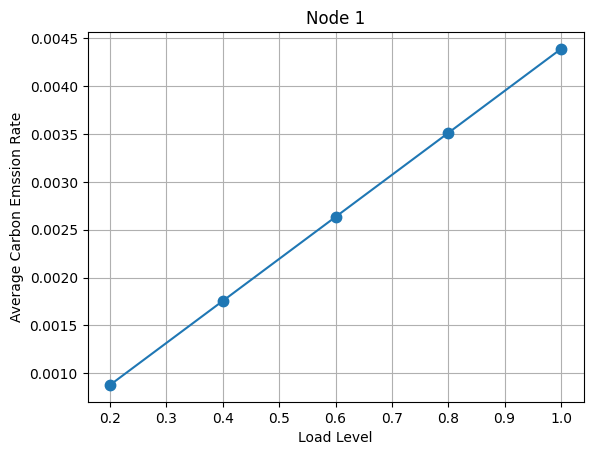

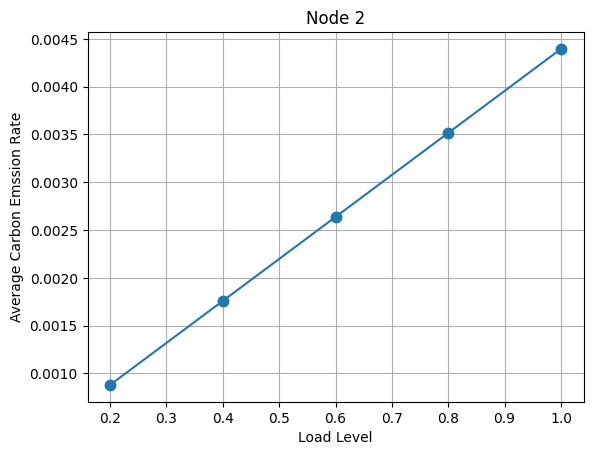

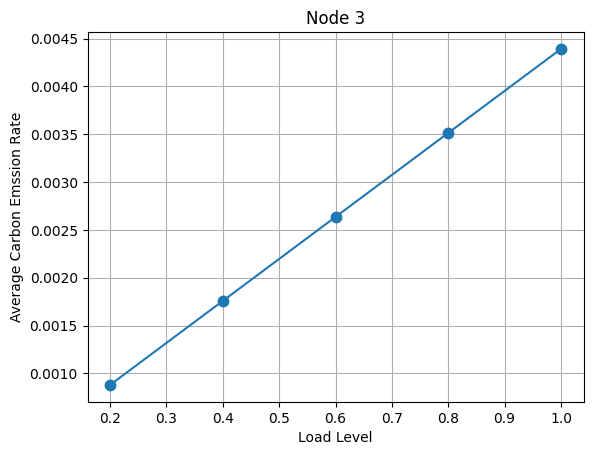

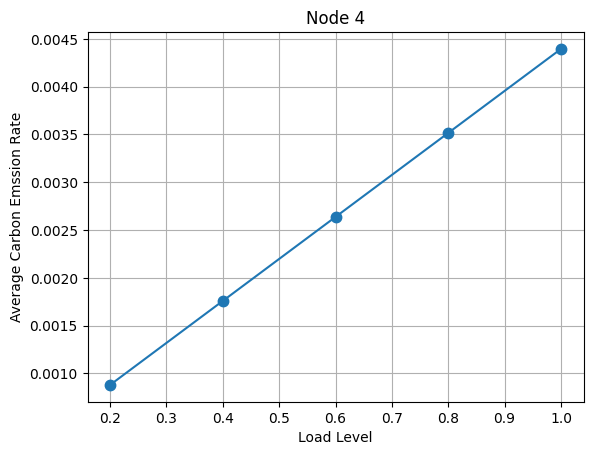

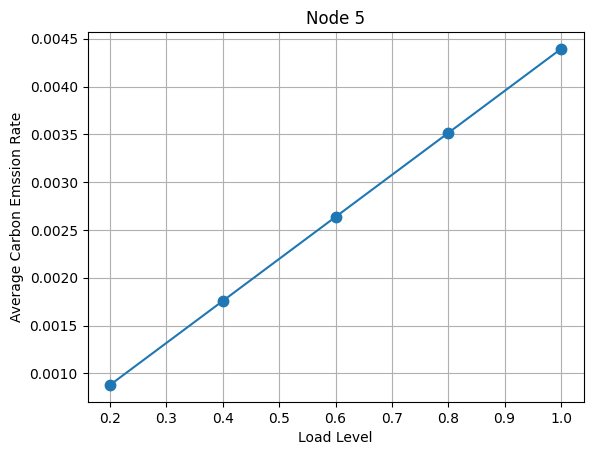

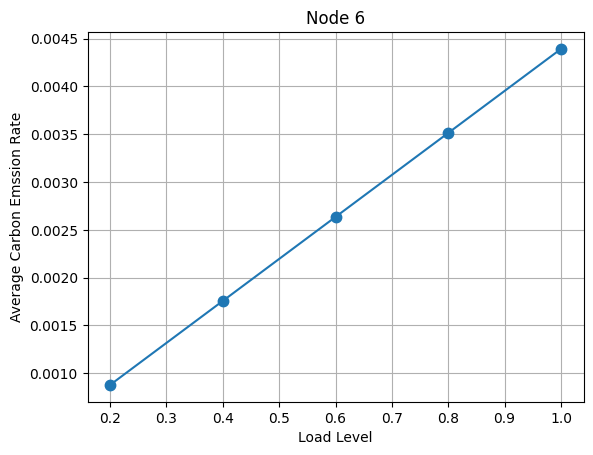

In [44]:
for n in range(num_buses):
    plt.title("Node " + str(n+1))
    plt.xlabel("Load Level")
    plt.ylabel("Average Carbon Emssion Rate")
    plt.plot([0.2,0.4,0.6,0.8,1.0], res[:, n], marker=".", markersize=15)
    plt.grid()
    plt.show()